### Loading the super-tensor and creating the temporal networks

In this notebook we will explote the class __temporal_nets__, this class load a ''super tensor'' which consists of  pairwise coherences as compute network theory measuments.

In [77]:
# Importing the temporal network class
from   GDa.temporal_network  import temporal_network
import numpy                 as     np
import networkx              as     nx
import matplotlib.pyplot     as     plt
import scipy.signal
import time
from   tqdm                  import tqdm
from   joblib                import Parallel, delayed
from   scipy                 import stats

# Just an auxiliary function to sommoth plots
def smooth(x, w):
    return scipy.signal.fftconvolve(x, np.ones(w)/w, mode='same')

To instantiate the __temporal_network__ we have to supply the monkey name, the session, and date to its constructor.

In [78]:
# Instantiating a temporal network object
net =  temporal_network(monkey='lucy', session=1, date=150128)

When instantiated, the temporal network object will load the recording info for the monkey, date, and sesion specified as well as the super tensor;

The super-tensor has dimensions [Number of pairs, Number of frequency bands, Number of trials * Time] (i.e., the trials are concatenated). So far we are using the following bands:

- $\theta$  = [4,8]  Hz;
- $\alpha$  = [8,15]  Hz;
- $\beta$   = [15,30]  Hz;
- $\gamma$  = [30,60]  Hz;

It is possible to check which recording information was recordes by acessing the __session_info__ dictionary:

In [79]:
print('Recording info available:\n')
print(list(net.session_info.keys()))

Recording info available:

['nC', 'nP', 'nT', 'pairs', 'indt', 'fsample', 'tarray', 'channels_labels', 'dcue', 'dsm', 'stim', 'indch', 'areas', 't_cue_on', 't_cue_off', 't_match_on']


We can plot the super tensor to visualize the time series of link strength for each band (here we plot 10 trials for better visualization).

Text(0.5, 0, 'Time [a.u]')

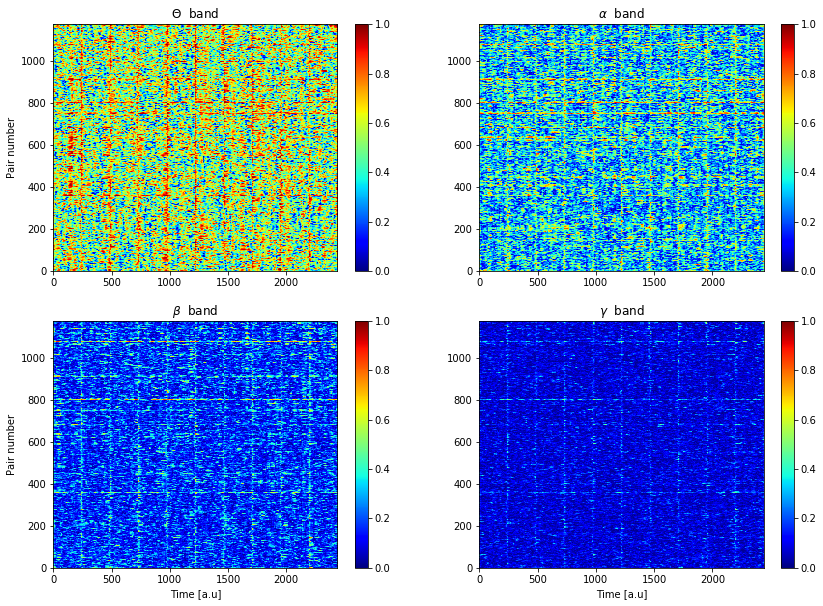

In [80]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.imshow(net.super_tensor[:,0,:10*len(net.tarray)], aspect='auto', cmap='jet', origin='lower', vmin=0, vmax=1); plt.colorbar()
plt.title(r'$\Theta$  band')
plt.ylabel('Pair number')
plt.subplot(2,2,2)
plt.imshow(net.super_tensor[:,1,:10*len(net.tarray)], aspect='auto', cmap='jet', origin='lower', vmin=0, vmax=1); plt.colorbar()
plt.title(r'$\alpha$  band')
plt.subplot(2,2,3)
plt.imshow(net.super_tensor[:,2,:10*len(net.tarray)], aspect='auto', cmap='jet', origin='lower', vmin=0, vmax=1); plt.colorbar()
plt.title(r'$\beta$  band')
plt.ylabel('Pair number')
plt.xlabel('Time [a.u]')
plt.subplot(2,2,4)
plt.imshow(net.super_tensor[:,3,:10*len(net.tarray)], aspect='auto', cmap='jet', origin='lower', vmin=0, vmax=1); plt.colorbar()
plt.title(r'$\gamma$  band')
plt.xlabel('Time [a.u]')

Notice that strong vertical stripes appear at the beggining/ending of each trials in the image above. This is due artifacts during wavelet estimation of pairwise coherences. Let's plot the super tensor for a single trial in the delta band to better visualize the artifacts.

Text(0.5, 0, 'Time [s]')

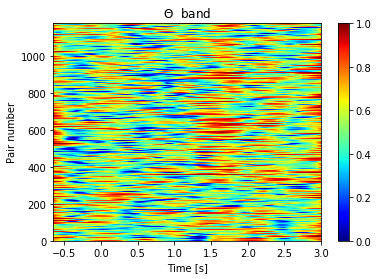

In [81]:
plt.imshow(net.super_tensor[:,0,:len(net.tarray)], aspect='auto', cmap='jet', origin='lower', extent=[-0.65, 3.00, 0, 1176], vmin=0, vmax=1); plt.colorbar()
plt.title(r'$\Theta$  band')
plt.ylabel('Pair number')
plt.xlabel('Time [s]')

To remove the border artifacts it is possible to instantiate the __temporal_network__ class specifing the parameter __trim_borders__ = True, and a value to the parameter __wt__. Doing that the firs and last __wt__ time points of the super tensor and the time array will be removed.

In [82]:
# Instantiating a temporal network object specifing trim_borders and wt.
net =  temporal_network(monkey='lucy', session=1, date=150128, trim_borders=True, wt=20)

Now let's plot the super tensor for the first ten trials again:

Text(0.5, 0, 'Time [a.u]')

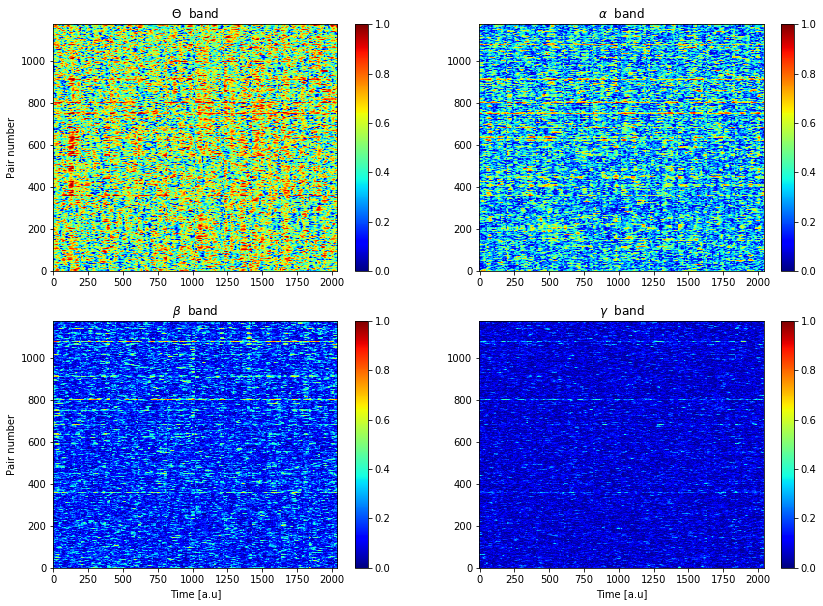

In [83]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.imshow(net.super_tensor[:,0,:10*len(net.tarray)], aspect='auto', cmap='jet', origin='lower', vmin=0, vmax=1); plt.colorbar()
plt.title(r'$\Theta$  band')
plt.ylabel('Pair number')
plt.subplot(2,2,2)
plt.imshow(net.super_tensor[:,1,:10*len(net.tarray)], aspect='auto', cmap='jet', origin='lower', vmin=0, vmax=1); plt.colorbar()
plt.title(r'$\alpha$  band')
plt.subplot(2,2,3)
plt.imshow(net.super_tensor[:,2,:10*len(net.tarray)], aspect='auto', cmap='jet', origin='lower', vmin=0, vmax=1); plt.colorbar()
plt.title(r'$\beta$  band')
plt.ylabel('Pair number')
plt.xlabel('Time [a.u]')
plt.subplot(2,2,4)
plt.imshow(net.super_tensor[:,3,:10*len(net.tarray)], aspect='auto', cmap='jet', origin='lower', vmin=0, vmax=1); plt.colorbar()
plt.title(r'$\gamma$  band')
plt.xlabel('Time [a.u]')

Observe that now the vertical are gone.

Some of the network theory measures can be applied to the binarized version of the network and in order to do so it is necessary to define thresholds for the coherence values

The super tensor can be converted to a adjacency tensor by using the method __convert_to_adjacency__:

In [7]:
net.convert_to_adjacency()

The adjacency tensor has dimensions $[nC, nC,bands,Trials*time]$, where $nC$ is the number of channels, and bands the number of frequency bands.

In [8]:
print('Adjacency tensor shape = ' + str( net.A.shape) )

Adjacency tensor shape = (49, 49, 4, 110160)


Let's plot one layer of the adjacency tensor below:

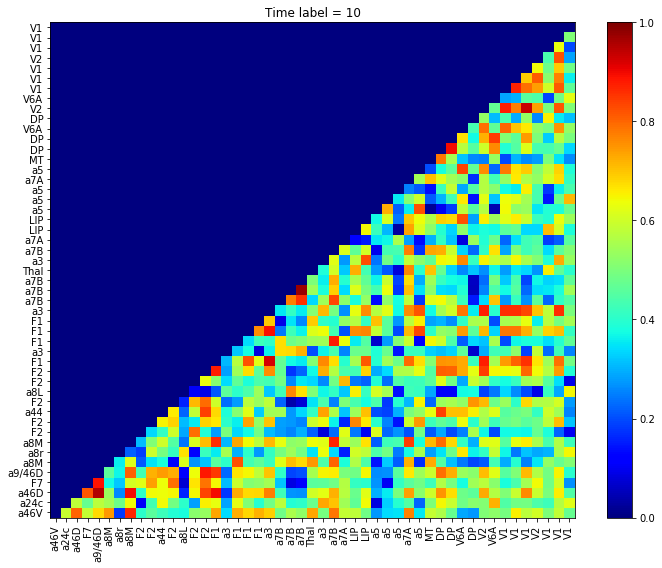

In [9]:
plt.figure(figsize=(10,8))
plt.imshow(net.A[:,:,0,10],aspect='auto',cmap='jet',origin='lower', vmin=0, vmax=1);plt.colorbar()
plt.title('Time label = ' + str(10))
plt.xticks(range(49), net.session_info['areas'], rotation = 90)
plt.yticks(range(49), net.session_info['areas'])
plt.tight_layout()

In [10]:
net.compute_coherence_thresholds(q = .80)

In [11]:
net.coh_thr

{'0': array([0.69730076]),
 '1': array([0.47403168]),
 '2': array([0.25120367]),
 '3': array([0.12849101])}

In [12]:
#net.compute_nodes_degree(0, thr = None)
#net.compute_nodes_degree(1, thr = None)
#net.compute_nodes_degree(2, thr = None)
#net.compute_nodes_degree(3, thr = None)
Parallel(n_jobs=4, backend='threading', timeout=1e6)(
    delayed(net.compute_nodes_degree)(band, thr=None) for band in range(4) )

[None, None, None, None]

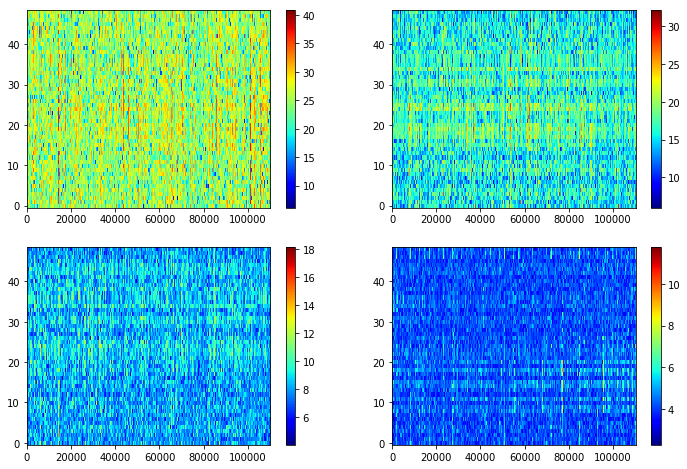

In [13]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.imshow(net.node_degree[0,:,0,:], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(net.node_degree[0,:,1,:], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(net.node_degree[0,:,2,:], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(net.node_degree[0,:,3,:], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()

In [14]:
net.node_degree[0,:,0,:]

array([[24.84158813, 24.65259349, 24.51609658, ..., 33.6428065 ,
        33.57778434, 33.48097028],
       [23.72848685, 23.7251811 , 23.72393405, ..., 31.21118081,
        31.63775312, 31.91934429],
       [22.93975496, 23.03083161, 23.2831855 , ..., 29.59105029,
        29.38831527, 29.16502776],
       ...,
       [17.78876591, 17.87988476, 18.07836282, ..., 26.90280644,
        27.32459965, 27.68686124],
       [24.01307842, 24.13620059, 24.29730041, ..., 26.34131385,
        27.28098749, 28.14387972],
       [24.01803286, 23.77227834, 23.51486781, ..., 31.13055562,
        31.40054994, 31.62951424]])

In [16]:
for i in range(540):
    #plt.plot(net.tarray, net.node_degree[0,:,0,:244].sum(axis=0))
    s_d = net.node_degree[0,:,1,i*len(net.tarray):(i+1)*len(net.tarray)].sum(axis=0)
    plt.plot(net.tarray, s_d)
    plt.title('Alpha band, trial = ' + str(i))
    plt.ylim([s_d.min()-0.1, s_d.max()+0.1])
    plt.xlim([-0.65,3])
    plt.ylabel('Summed node strength')
    plt.xlabel('Time')
    #plt.plot(net.tarray, net.node_degree[0,:,2,:244].sum(axis=0))
    #plt.plot(net.tarray, net.node_degree[0,:,3,:244].sum(axis=0))
    plt.vlines(0, s_d.min()-0.1, s_d.max()+0.1, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((net.session_info['t_cue_off'][i]-net.session_info['t_cue_on'][i])/1000, s_d.min()-0.1, s_d.max()+0.1, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((net.session_info['t_match_on'][i]-net.session_info['t_cue_on'][i])/1000, s_d.min()-0.1, s_d.max()+0.1, linestyle='--', linewidth = 3, color = 'g')
    plt.savefig('figures/summed_st_'+str(i)+'.png')
    plt.close()

Text(0.5, 0, 'Time [s]')

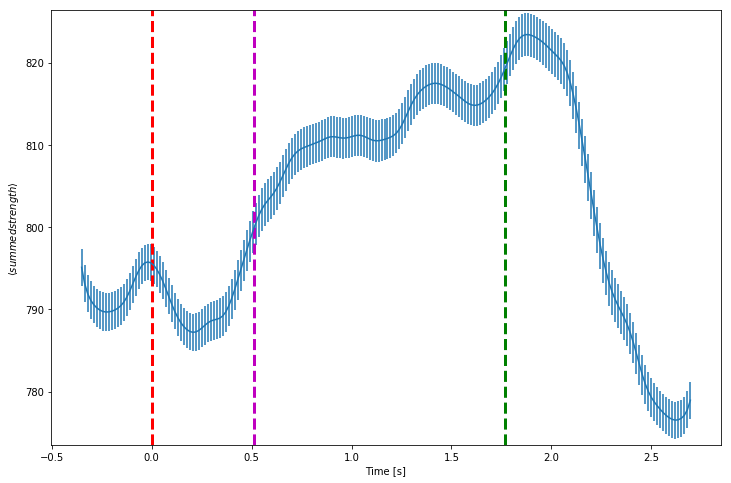

In [26]:
s_d = net.node_degree[0,:,1,:].sum(axis=0)
s_d = s_d.reshape(540,len(net.tarray))
plt.figure(figsize=(12,8))
s_d_m = s_d.mean(axis = 0)
s_d_e = s_d.std(axis = 0) / (s_d.shape[0]**0.5)
s_d_m = s_d_m
s_d_e = s_d_e
plt.errorbar(net.tarray, s_d_m, s_d_e)
#plt.imshow(s_d[:,10:-10], aspect = 'auto', cmap = 'viridis', origin = 'lower', extent=[-0.65,3,1,540])
#plt.colorbar()
plt.ylim([s_d_m.min()-3, s_d_m.max()+3])
plt.vlines(0, s_d_m.min()-3, s_d_m.max()+3, linestyle='--', linewidth = 3, color = 'r')
plt.vlines((net.session_info['t_cue_off']-net.session_info['t_cue_on']).mean()/1000, 
           s_d_m.min()-3, s_d_m.max()+3, linestyle='--', linewidth = 3, color = 'm')
plt.vlines((net.session_info['t_match_on']-net.session_info['t_cue_on']).mean()/1000, 
           s_d_m.min()-3, s_d_m.max()+3, linestyle='--', linewidth = 3, color = 'g')
plt.ylabel(r'$\langle summed strength \rangle$')
plt.xlabel('Time [s]')

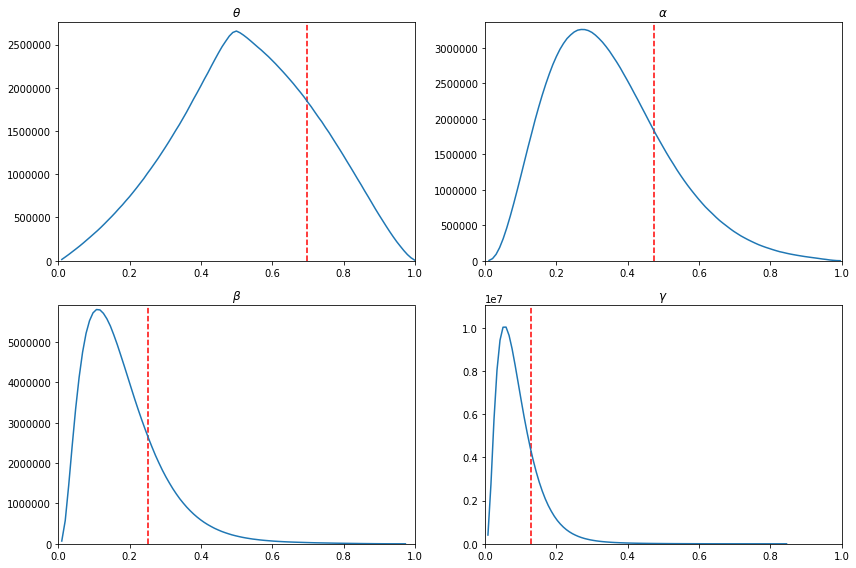

In [36]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
n1, x1 = np.histogram(net.super_tensor[:,0,:].flatten(order='C'), 100)
plt.plot(x1[1:],n1)
plt.ylim([0, n1.max()+1e5])
plt.xlim([0,1])
plt.vlines(net.coh_thr['0'], 0, n1.max()+1e5, linestyle='--', color='r')
plt.title(r'$\theta$')
plt.subplot(2,2,2)
n2, x2 = np.histogram(net.super_tensor[:,1,:].flatten(), 100)
plt.plot(x2[1:],n2)
plt.ylim([0, n2.max()+1e5])
plt.xlim([0,1])
plt.vlines(net.coh_thr['1'], 0, n2.max()+1e5, linestyle='--', color='r')
plt.title(r'$\alpha$')
plt.subplot(2,2,3)
n3, x3 = np.histogram(net.super_tensor[:,2,:].flatten(), 100)
plt.plot(x3[1:],n3)
plt.ylim([0, n3.max()+1e5])
plt.xlim([0,1])
plt.vlines(net.coh_thr['2'], 0, n3.max()+1e5, linestyle='--', color='r')
plt.title(r'$\beta$')
plt.subplot(2,2,4)
n4, x4 = np.histogram(net.super_tensor[:,3,:].flatten(), 100)
plt.plot(x4[1:],n4)
plt.ylim([0, n4.max()+1e6])
plt.xlim([0,1])
plt.vlines(net.coh_thr['3'], 0, n4.max()+1e6, linestyle='--', color='r')
plt.title(r'$\gamma$')
plt.tight_layout()

In [37]:
net.create_stages_time_grid()

In [38]:
stages = np.zeros([net.session_info['nT'],len(net.tarray)])
ii     = [net.t_baseline.reshape(net.session_info['nT'],len(net.tarray)), 
          net.t_cue.reshape(net.session_info['nT'],len(net.tarray)), 
          net.t_delay.reshape(net.session_info['nT'],len(net.tarray)),
          net.t_match.reshape(net.session_info['nT'],len(net.tarray))]
for i in range(4):
    stages = stages - i * ii[i]

Text(0.5, 0, 'Time')

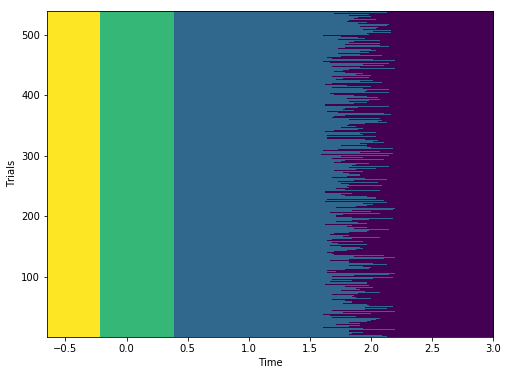

In [39]:
plt.figure(figsize = (8,6))
plt.imshow(stages, aspect='auto',cmap='viridis',origin='lower', extent=[-0.65,3,1,540])
plt.ylabel('Trials')
plt.xlabel('Time')

array([[0.25285816, 0.24476804, 0.24433118, ..., 0.17175703, 0.16426639,
        0.16076569],
       [0.32982492, 0.32261152, 0.3108273 , ..., 0.08861396, 0.11232094,
        0.13546855],
       [0.6570918 , 0.63874099, 0.61402564, ..., 0.20261618, 0.21653378,
        0.23124912],
       ...,
       [0.67809705, 0.6673429 , 0.6563219 , ..., 0.77979696, 0.77650513,
        0.77739952],
       [0.20354022, 0.19645183, 0.19194907, ..., 0.65716548, 0.65947834,
        0.66222957],
       [0.3616658 , 0.36133192, 0.36265656, ..., 0.74281865, 0.74169499,
        0.74063806]])

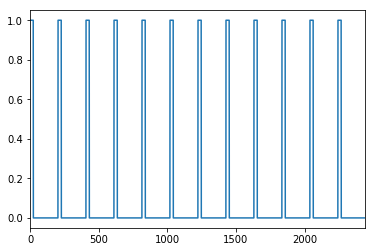

In [40]:
plt.plot(net.t_baseline)
plt.xlim([0,2440])
net.super_tensor[:,1,net.t_baseline]

In [41]:
net.node_degree[0,:,0,:].shape

(49, 110160)

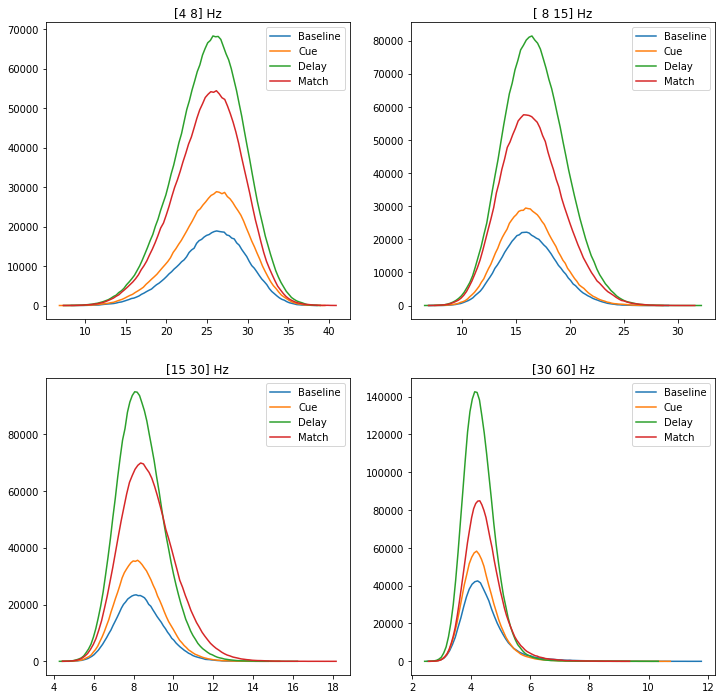

In [43]:
plt.figure(figsize=(12,12))
for i in range(4):
    plt.subplot(2,2,i+1)
    n1,x1 = np.histogram(net.node_degree[0,:,i,:][:, net.t_baseline], 100)
    n2,x2 = np.histogram(net.node_degree[0,:,i,:][:, net.t_cue], 100)
    n3,x3 = np.histogram(net.node_degree[0,:,i,:][:, net.t_delay], 100)
    n4,x4 = np.histogram(net.node_degree[0,:,i,:][:, net.t_match], 100)
    plt.plot(x1[2:], n1[1:], label='Baseline')
    plt.plot(x2[2:], n2[1:], label='Cue')
    plt.plot(x3[2:], n3[1:], label='Delay')
    plt.plot(x4[2:], n4[1:], label='Match')
    plt.title(str(net.bands[i]) + ' Hz')
    plt.legend()

In [ ]:
#Parallel(n_jobs=4, backend='threading', timeout=1e6)(
#    delayed(net.compute_nodes_clustering)(band, thr=net.coh_thr[str(i)]) for band in range(4) )
net.compute_nodes_clustering(band=0, thr=net.coh_thr['0'])
net.compute_nodes_clustering(band=1, thr=net.coh_thr['1'])
net.compute_nodes_clustering(band=2, thr=net.coh_thr['2'])
net.compute_nodes_clustering(band=3, thr=net.coh_thr['3'])

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.imshow(net.clustering[1,:,0,:], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(net.clustering[1,:,1,:], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(net.clustering[1,:,2,:], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(net.clustering[1,:,3,:], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()

In [ ]:
w = 1
plt.figure(figsize=(12,12))
for i in range(4):
    plt.subplot(2,2,i+1)
    n1,x1 = np.histogram(net.clustering[1,:,i,net.t_baseline].flatten(), 30)
    n2,x2 = np.histogram(net.clustering[1,:,i,net.t_cue].flatten(), 30)
    n3,x3 = np.histogram(net.clustering[1,:,i,net.t_delay].flatten(), 30)
    n4,x4 = np.histogram(net.clustering[1,:,i,net.t_match].flatten(), 30)
    plt.plot(x1[2:], smooth(n1[1:], w), 's-', label='Baseline')
    plt.plot(x2[2:], smooth(n2[1:], w), 's-', label='Cue')
    plt.plot(x3[2:], smooth(n3[1:], w), 's-', label='Delay')
    plt.plot(x4[2:], smooth(n4[1:], w), 's-', label='Match')
    plt.title(str(net.bands[i]) + ' Hz')
    plt.legend()

In [ ]:
net.compute_nodes_coreness(band=0, thr=net.coh_thr['0'])
net.compute_nodes_coreness(band=1, thr=net.coh_thr['1'])
net.compute_nodes_coreness(band=2, thr=net.coh_thr['2'])
net.compute_nodes_coreness(band=3, thr=net.coh_thr['3'])

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.imshow(net.coreness[1,:,0,:], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(net.coreness[1,:,1,:], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(net.coreness[1,:,2,:], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(net.coreness[1,:,3,:], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()

In [ ]:
w = 5
plt.figure(figsize=(12,12))
for i in range(4):
    plt.subplot(2,2,i+1)
    n1,x1 = np.histogram(net.coreness[1,:,i, net.t_baseline].flatten(), 30)
    n2,x2 = np.histogram(net.coreness[1,:,i, net.t_cue].flatten(), 30)
    n3,x3 = np.histogram(net.coreness[1,:,i, net.t_delay].flatten(), 30)
    n4,x4 = np.histogram(net.coreness[1,:,i, net.t_match].flatten(), 30)
    plt.plot(x1[1:], smooth(n1[:],w), 's-', label='Baseline')
    plt.plot(x2[1:], smooth(n2[:],w), 's-', label='Cue')
    plt.plot(x3[1:], smooth(n3[:],w), 's-', label='Delay')
    plt.plot(x4[1:], smooth(n4[:],w), 's-', label='Match')
    plt.title(str(net.bands[i]) + ' Hz')
    plt.legend()

In [ ]:
net.compute_nodes_betweenes(None, band=0, thr=net.coh_thr['0'])
net.compute_nodes_betweenes(None, band=1, thr=net.coh_thr['1'])
net.compute_nodes_betweenes(None, band=2, thr=net.coh_thr['2'])
net.compute_nodes_betweenes(None, band=3, thr=net.coh_thr['3'])

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.imshow(net.betweenes[1,:,0,:], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(net.betweenes[1,:,1,:], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(net.betweenes[1,:,2,:], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(net.betweenes[1,:,3,:], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()

In [ ]:
w = 3
plt.figure(figsize=(12,12))
for i in range(4):
    plt.subplot(2,2,i+1)
    n1,x1 = np.histogram(net.betweenes[1,:,i, net.t_baseline].flatten(), 30)
    n2,x2 = np.histogram(net.betweenes[1,:,i, net.t_cue].flatten(), 30)
    n3,x3 = np.histogram(net.betweenes[1,:,i, net.t_delay].flatten(), 30)
    n4,x4 = np.histogram(net.betweenes[1,:,i, net.t_match].flatten(), 30)
    plt.plot(x1[1:], smooth(n1[:],w), 's-', label='Baseline')
    plt.plot(x2[1:], smooth(n2[:],w), 's-', label='Cue')
    plt.plot(x3[1:], smooth(n3[:],w), 's-', label='Delay')
    plt.plot(x4[1:], smooth(n4[:],w), 's-', label='Match')
    plt.title(str(net.bands[i]) + ' Hz')
    plt.legend()

In [ ]:
from GDa.graphics.plot_brain_sketch import plot_node_brain_sketch, plot_edge_brain_sketch

In [ ]:
#for i in range(244):
#    plt.figure()
#    plot_node_brain_sketch(net.session_info['channels_labels'].astype(int), net.A[:,0,i])

In [ ]:
# Brain nets
'''
for i in tqdm( range(244) ):
    if net.tarray[i] < 0:
        color = 'r'
        title = 'Baseline'
    if net.tarray[i] >= 0 and net.tarray[i] < (net.session_info['t_cue_off'][0]-net.session_info['t_cue_on'][0])/1000:
        color = 'b'
        title = 'Cue'
    if net.tarray[i] >= (net.session_info['t_cue_off'][0]-net.session_info['t_cue_on'][0])/1000 and net.tarray[i] < (net.session_info['t_match_on'][0]-net.session_info['t_cue_on'][0])/1000:
        color = 'm'
        title = 'Delay'
    if net.tarray[i] >= (net.session_info['t_match_on'][0]-net.session_info['t_cue_on'][0])/1000:
        color = 'k'
        title = 'Match'
    w = net.super_tensor[:,0,i]>.7
    plot_edge_brain_sketch(net.session_info['pairs'], net.session_info['channels_labels'].astype(int), w)
    plt.title(title)
    plt.savefig('figures/net_'+str(i)+'.png')
    plt.close()
'''

In [ ]:
# COreness maps
'''
plt.figure(figsize=(12,8))
for i in tqdm( range(net.session_info['nT']) ):
    plt.figure()
    plt.imshow(net.coreness['1']['b'][:,i*244:(i+1)*244], aspect = 'auto', cmap = 'jet', origin = 'lower', vmax=15, extent=[-0.65,3.00,0,48]); plt.colorbar()
    plt.vlines(0, 0, 48, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((net.session_info['t_cue_off'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((net.session_info['t_match_on'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'g')
    plt.yticks(range(49), net.session_info['areas'])
    plt.title('Trial = ' + str(i+1) + ', threshold = 0.7')
    plt.savefig('figures/core_alpha_'+str(i)+'.png')
    plt.close()
'''

In [ ]:
'''
plt.figure(figsize=(12,8))
for i in tqdm( range(net.session_info['nT']) ):
    plt.figure()
    plt.imshow(net.clustering['1']['b'][:,i*244:(i+1)*244], aspect = 'auto', cmap = 'jet', origin = 'lower', vmax=1, extent=[-0.65,3.00,0,48]); plt.colorbar()
    plt.vlines(0, 0, 48, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((net.session_info['t_cue_off'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((net.session_info['t_match_on'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'g')
    plt.yticks(range(49), net.session_info['areas'])
    plt.title('Trial = ' + str(i+1) + ', threshold = ' + str(net.coh_thr['1']))
    plt.savefig('figures/clustering_alpha_'+str(i)+'.png')
    plt.close()
'''

In [ ]:
i=0
plt.figure(figsize=(12,8))
plt.imshow(net.coreness['b']['1'][:,(i)*244:(i+1)*244], aspect = 'auto', cmap = 'jet', origin = 'lower', vmax=15, extent=[-0.65,3.00,0,48]); plt.colorbar()
plt.vlines(0, 0, 48, linestyle='--', linewidth = 3, color = 'r')
plt.vlines((net.session_info['t_cue_off'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'm')
plt.vlines((net.session_info['t_match_on'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'g')
plt.yticks(range(49), net.session_info['areas'])
plt.title('Trial = ' + str(i+1) + ', threshold = 0.7')

In [ ]:
i=0
plt.figure(figsize=(12,8))
plt.imshow(net.clustering['b']['1'][:,(i)*244:(i+1)*244], aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[-0.65,3.00,0,48]); plt.colorbar()
plt.vlines(0, 0, 48, linestyle='--', linewidth = 3, color = 'r')
plt.vlines((net.session_info['t_cue_off'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'm')
plt.vlines((net.session_info['t_match_on'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'g')
plt.yticks(range(49), net.session_info['areas'])
plt.title('Trial = ' + str(i+1) + ', threshold = ' + str(net.coh_thr['1']))

In [ ]:
i=0
plt.figure(figsize=(12,8))
plt.imshow(net.node_degree['w']['1'][:,(i)*244:(i+1)*244], aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[-0.65,3.00,0,48]); plt.colorbar()
plt.vlines(0, 0, 48, linestyle='--', linewidth = 3, color = 'r')
plt.vlines((net.session_info['t_cue_off'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'm')
plt.vlines((net.session_info['t_match_on'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'g')
plt.yticks(range(49), net.session_info['areas'])
plt.title('Trial = ' + str(i+1) + ', threshold = 0.7')

In [ ]:
class test:
    
    def __init__(self,): 
        
        self.a = np.zeros(40)
    
    def set_a(self, i):
        self.a[i] = 2*i + 1
        
t = test()

print('Initial value of a = ' + str(t.a) )

Parallel(n_jobs=-40, backend='loky', timeout=1e6)(delayed(t.set_a)(i) for i in range(40) )

print('Final value of a = ' + str(t.a) )

In [ ]:
net.compute_nodes_clustering_layerwise(band=0, observation=0)

In [ ]:
w=net.clustering['0']['w'][:,0]

In [ ]:
net.compute_nodes_clustering_layerwise(band=0, observation=0, thr=net.coh_thr['0'])

In [ ]:
b=net.clustering['0']['b'][:,0]

In [ ]:
plt.plot(w)
plt.plot(b)
net.A.shape[3]

In [ ]:
#start = time.time()

#Parallel(n_jobs=-1, backend='threading', timeout=1e6)(
#    delayed(net.compute_nodes_clustering_layerwise)(0, observation=t, thr=net.coh_thr['0']) for t in range(net.A.shape[3]) )

#end = time.time()
#print(end - start)

In [ ]:
# Alpha
start = time.time()
from sklearn.decomposition import NMF
model = NMF(n_components=50, init='random', random_state=0)
W = model.fit_transform(net.super_tensor[:,1,:])
H = model.components_
end = time.time()
print(end - start)

In [ ]:
W.shape

In [ ]:
H.shape

In [ ]:
m = np.zeros([49,49,50])
for p in range(net.session_info['pairs'].shape[0]):
    i, j = net.session_info['pairs'][p,0], net.session_info['pairs'][p,1]
    m[i,j,:] = W[p,:]

In [ ]:
for i in range(50):
    plt.figure(figsize=(12,8))
    plt.imshow(m[:,:,i]+m[:,:,i].T, aspect='auto', cmap = 'jet', origin = 'lower');plt.colorbar()
    plt.savefig('figures/nmf_'+str(i)+'.png')
    plt.title('Factor = ' + str(i))
    plt.close()

In [ ]:
rec = np.matmul(W,H)
np.abs(net.super_tensor[:,1,:]-rec).mean()

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.imshow(net.super_tensor[:,1,:2440],aspect='auto',origin='lower',cmap='jet');plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(rec[:,:2440],aspect='auto',origin='lower',cmap='jet');plt.colorbar()

In [ ]:
net.A.shape

In [ ]:
adj1 = net.A[:,:,0,0]
adj2 = net.A[:,:,0,0] + net.A[:,:,0,0].T 
g1   = nx.Graph(adj1>.7)
g2   = nx.Graph(adj2>.7)

In [ ]:
nx.degree(g1)

In [ ]:
nx.degree(g2)

In [ ]:
net.betweenes

In [ ]:

ebc = nx.edge_betweenness_centrality(g, 49, seed=0)

In [ ]:
len( dict(ebc).values() )

In [ ]:
L = np.zeros(244)
for t in tqdm( range(244) ):
    try:
        adj  = net.A[:,:,1,t] + net.A[:,:,1,t].T
        g    = nx.Graph(adj>net.coh_thr['1'][0])
        L[t] = nx.average_shortest_path_length(g) 
    except:
        continue

In [ ]:
plt.plot(L)

In [ ]:
net.A.shape

In [ ]:
net.coh_thr['1']

In [ ]:
plt.imshow(net.A[:,:,1,t]>net.coh_thr['1'], aspect = 'auto', cmap = 'jet')

In [ ]:
net.coh_thr['1']

In [ ]:
g.edges

In [ ]:
plt.plot(np.repeat(net.session_info['stim'], 540)[:30*244])

In [ ]:
idx=np.argsort(np.repeat(net.session_info['stim'], 244))

In [ ]:
idx

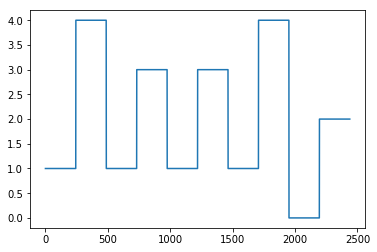

In [14]:
plt.plot( np.repeat(net.session_info['stim'], 244)[:2440] ) 

In [16]:
net.session_info['stim'][:10]

array([1., 4., 1., 3., 1., 3., 1., 4., 0., 2.])

In [4]:
net.create_stim_grid()

In [5]:
net.stim_grid.shape

(5, 131760)

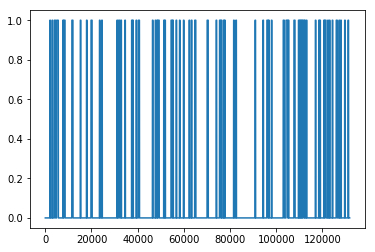

In [14]:
plt.plot(net.stim_grid[0,:])

In [8]:
net.session_info['stim'][:10]

array([1., 4., 1., 3., 1., 3., 1., 4., 0., 2.])

In [15]:
net.stim_grid[0,:].shape

(131760,)

In [19]:
net.tarray

array([-0.65 , -0.635, -0.62 , -0.605, -0.59 , -0.575, -0.56 , -0.545,
       -0.53 , -0.515, -0.5  , -0.485, -0.47 , -0.455, -0.44 , -0.425,
       -0.41 , -0.395, -0.38 , -0.365, -0.35 , -0.335, -0.32 , -0.305,
       -0.29 , -0.275, -0.26 , -0.245, -0.23 , -0.215, -0.2  , -0.185,
       -0.17 , -0.155, -0.14 , -0.125, -0.11 , -0.095, -0.08 , -0.065,
       -0.05 , -0.035, -0.02 , -0.005,  0.01 ,  0.025,  0.04 ,  0.055,
        0.07 ,  0.085,  0.1  ,  0.115,  0.13 ,  0.145,  0.16 ,  0.175,
        0.19 ,  0.205,  0.22 ,  0.235,  0.25 ,  0.265,  0.28 ,  0.295,
        0.31 ,  0.325,  0.34 ,  0.355,  0.37 ,  0.385,  0.4  ,  0.415,
        0.43 ,  0.445,  0.46 ,  0.475,  0.49 ,  0.505,  0.52 ,  0.535,
        0.55 ,  0.565,  0.58 ,  0.595,  0.61 ,  0.625,  0.64 ,  0.655,
        0.67 ,  0.685,  0.7  ,  0.715,  0.73 ,  0.745,  0.76 ,  0.775,
        0.79 ,  0.805,  0.82 ,  0.835,  0.85 ,  0.865,  0.88 ,  0.895,
        0.91 ,  0.925,  0.94 ,  0.955,  0.97 ,  0.985,  1.   ,  1.015,
      

In [20]:
net.tarray[20:-20]

array([-0.35 , -0.335, -0.32 , -0.305, -0.29 , -0.275, -0.26 , -0.245,
       -0.23 , -0.215, -0.2  , -0.185, -0.17 , -0.155, -0.14 , -0.125,
       -0.11 , -0.095, -0.08 , -0.065, -0.05 , -0.035, -0.02 , -0.005,
        0.01 ,  0.025,  0.04 ,  0.055,  0.07 ,  0.085,  0.1  ,  0.115,
        0.13 ,  0.145,  0.16 ,  0.175,  0.19 ,  0.205,  0.22 ,  0.235,
        0.25 ,  0.265,  0.28 ,  0.295,  0.31 ,  0.325,  0.34 ,  0.355,
        0.37 ,  0.385,  0.4  ,  0.415,  0.43 ,  0.445,  0.46 ,  0.475,
        0.49 ,  0.505,  0.52 ,  0.535,  0.55 ,  0.565,  0.58 ,  0.595,
        0.61 ,  0.625,  0.64 ,  0.655,  0.67 ,  0.685,  0.7  ,  0.715,
        0.73 ,  0.745,  0.76 ,  0.775,  0.79 ,  0.805,  0.82 ,  0.835,
        0.85 ,  0.865,  0.88 ,  0.895,  0.91 ,  0.925,  0.94 ,  0.955,
        0.97 ,  0.985,  1.   ,  1.015,  1.03 ,  1.045,  1.06 ,  1.075,
        1.09 ,  1.105,  1.12 ,  1.135,  1.15 ,  1.165,  1.18 ,  1.195,
        1.21 ,  1.225,  1.24 ,  1.255,  1.27 ,  1.285,  1.3  ,  1.315,
      

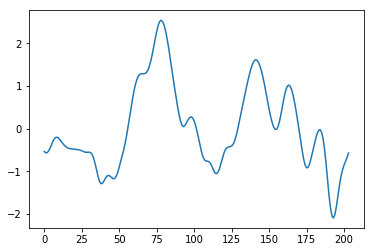

In [58]:
s_d = net.node_degree[0,:,1,:].sum(axis=0)
plt.plot((s_d[:204]-s_d[:204].mean())/s_d[:204].std() )


In [48]:
net.t_baseline

array([ True,  True,  True, ..., False, False, False])